In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
import sys
import os
from collections import Counter
from astrometry.util.fits import *
from astrometry.util.starutil_numpy import *
from astrometry.libkd.spherematch import *
sys.path.append('legacypipe/py')
from legacypipe.survey import LegacySurveyData
sys.path.insert(0, '/global/homes/d/dstn/desicode')
import desitarget.targetmask as targetmask

In [37]:
# COSMOS
ra,dec = 150.0, 2.2
radius = 2.0

In [3]:
survey = LegacySurveyData('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m')
south_survey = LegacySurveyData('/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south')

In [38]:
bricks = survey.get_bricks_near(ra, dec, radius + 0.2) # ~ 0.17 degree margin for brick size

In [5]:
len(bricks)

244

In [7]:
TT = []
for b in bricks:
    tfn = south_survey.find_file('tractor', brick=b.brickname)
    T = fits_table(tfn)
    #print(len(T), 'for brick', b.brickname)
    TT.append(T)
T = merge_tables(TT)
len(T)

1262762

In [8]:
T.cut(T.brick_primary)
len(T)

1231787

In [9]:
d = degrees_between(ra, dec, T.ra, T.dec)
T.cut(d < radius)
len(T)

1022519

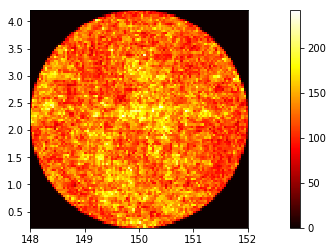

In [10]:
from astrometry.util.plotutils import *
plothist(T.ra, T.dec);
plt.axis('square');

In [11]:
#### FIBERFLUX here ####
T.mag_g = 22.5 - 2.5 * np.log10(T.fiberflux_g)
T.mag_r = 22.5 - 2.5 * np.log10(T.fiberflux_r)
T.mag_z = 22.5 - 2.5 * np.log10(T.fiberflux_z)
T.gr = T.mag_g - T.mag_r
T.rz = T.mag_r - T.mag_z

/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract
/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract


In [12]:
np.sum(T.mag_r < 24.0)

477876

In [13]:
# 0.1% have negative flux for each of g,z
Counter(np.isfinite(T.mag_z[T.mag_r < 24]))

Counter({True: 477209, False: 667})

In [14]:
Counter(np.isfinite(T.mag_g[T.mag_r < 24]))

Counter({True: 477308, False: 568})

In [15]:
T.cut(np.isfinite(T.gr) * np.isfinite(T.rz))
len(T)

997610

In [16]:
# Drop BRIGHT
T.cut((T.maskbits & 0x2) == 0)
len(T)

991502

In [17]:
P = T[T.type == 'PSF']
NP = T[T.type != 'PSF']
R = T[T.type == 'REX']
G = T[(T.type != 'PSF') * (T.type != 'REX')]
len(P), len(R), len(G)

(369557, 488250, 133695)

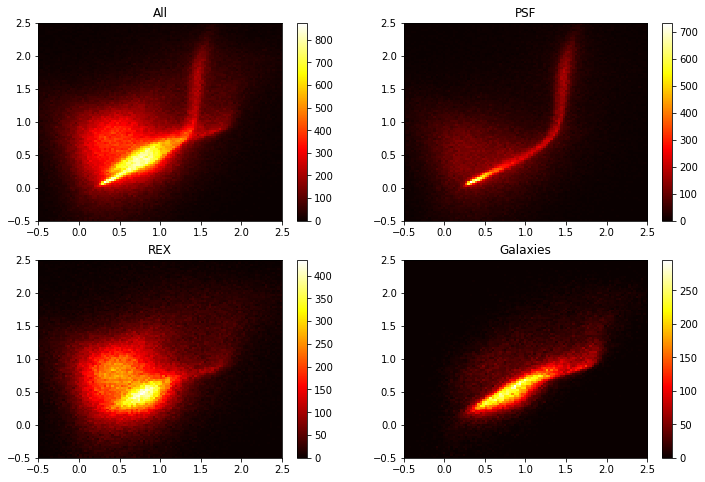

In [18]:
plt.figure(figsize=(12,8))
ha = dict(range=((-0.5,2.5),(-0.5,2.5)), doclf=False)
plt.subplot(2,2,1)
plothist(T.gr, T.rz, **ha);
plt.title('All')
plt.subplot(2,2,2)
plothist(P.gr, P.rz, **ha);
plt.title('PSF')
plt.subplot(2,2,3)
plothist(R.gr, R.rz, **ha);
plt.title('REX')
plt.subplot(2,2,4)
plothist(G.gr, G.rz, **ha);
plt.title('Galaxies');

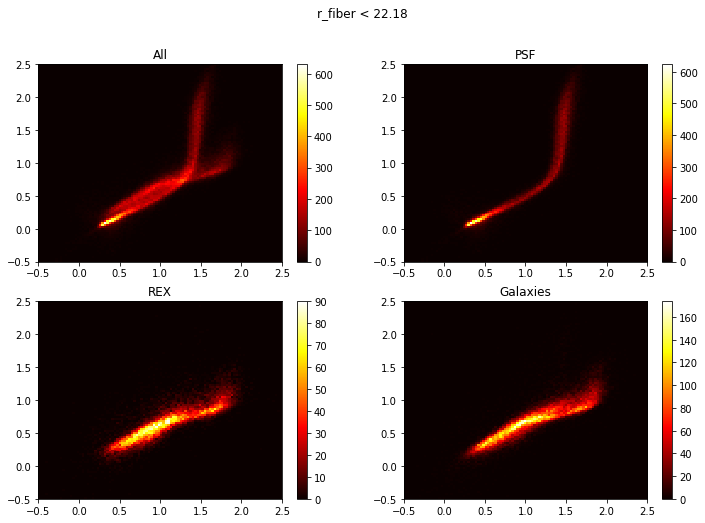

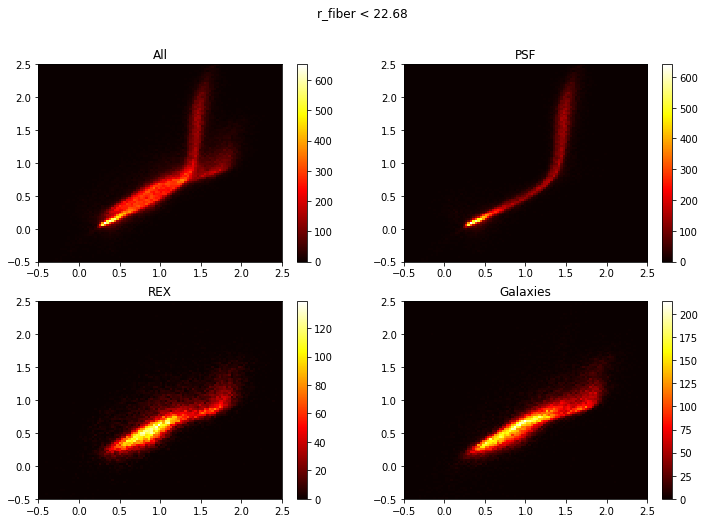

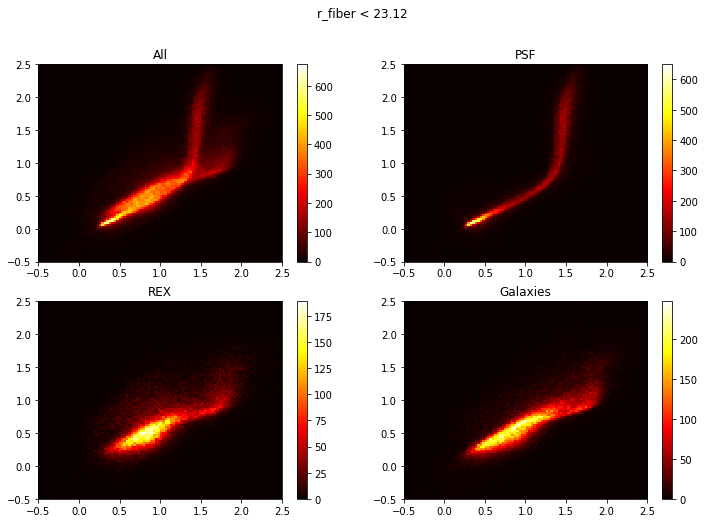

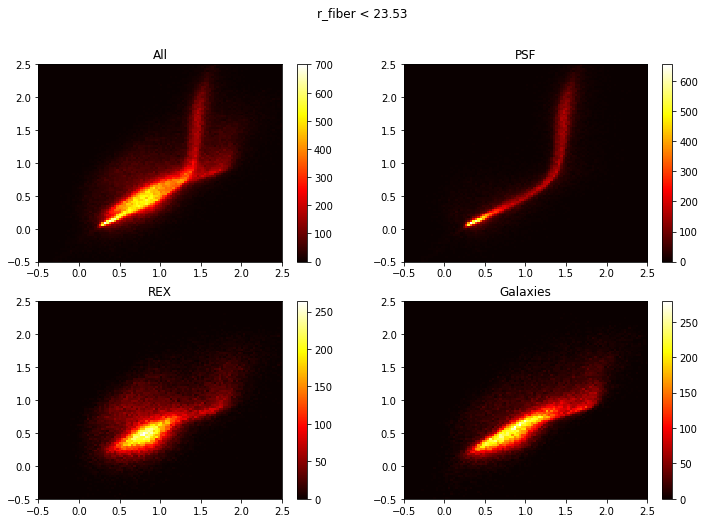

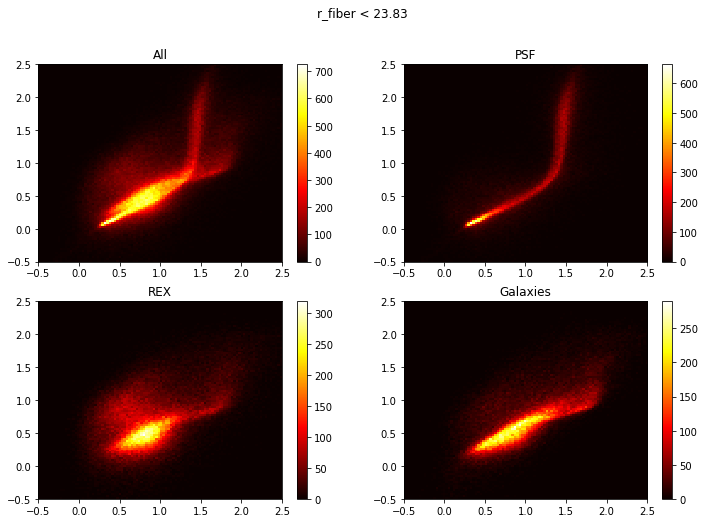

In [49]:
for icut,cut in enumerate([22.18, 22.68, 23.12, 23.53, 23.83]):
    plt.figure(figsize=(12,8))
    ha = dict(range=((-0.5,2.5),(-0.5,2.5)), doclf=False)
    plt.subplot(2,2,1)
    I = np.flatnonzero(T.mag_r < cut)
    plothist(T.gr[I], T.rz[I], **ha);
    plt.title('All')
    plt.subplot(2,2,2)
    I = np.flatnonzero(P.mag_r < cut)
    plothist(P.gr[I], P.rz[I], **ha);
    plt.title('PSF')
    plt.subplot(2,2,3)
    I = np.flatnonzero(R.mag_r < cut)
    plothist(R.gr[I], R.rz[I], **ha);
    plt.title('REX')
    plt.subplot(2,2,4)
    I = np.flatnonzero(G.mag_r < cut)
    plothist(G.gr[I], G.rz[I], **ha);
    plt.title('Galaxies');
    plt.suptitle('r_fiber < %s' % cut);
    plt.savefig('colorcolor-%i.png' % icut)
    plt.show()

In [50]:
pwd

'/global/u1/d/dstn'

In [30]:
# Match with DESI targets
targets = fits_table('/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/targets/main/resolve/dark/targets-dark-hp-106.fits')
d = degrees_between(ra, dec, targets.ra, targets.dec)
targets.cut(d < radius)
print(len(targets), 'targets')

53730 targets


In [20]:
m90s = {('all', 900): 21.76753507014028, ('red', 900): 21.76753507014028, ('green', 900): 21.5751503006012, ('blue', 900): 22.17635270541082, ('all', 1800): 22.31062124248497, ('red', 1800): 22.256513026052104, ('green', 1800): 22.142284569138276, ('blue', 1800): 22.683366733466933, ('all', 3600): 22.773547094188377, ('red', 3600): 22.789579158316634, ('green', 3600): 22.597194388777556, ('blue', 3600): 23.118236472945892, ('all', 7200): 23.227454909819638, ('red', 7200): 23.2875751503006, ('green', 7200): 22.977955911823646, ('blue', 7200): 23.5250501002004, ('all', 14400): 23.65330661322645, ('red', 14400): 23.725450901803608, ('green', 14400): 23.438877755511022, ('blue', 14400): 23.827655310621243}
t = 900
# Round m90 mag cuts to 2 decimal digits
newm90 = {}
for k,v in m90s.items():
    newm90[k] = np.round(v, decimals=2)
m90s = newm90

In [21]:
times = [900, 1800, 3600, 7200, 14400]


Exptime 900
red  :  17476 < 21.77  (27.3 % DESI)
green:   8505 < 21.58  (21.8 % DESI)
blue :  11569 < 22.18  (15.8 % DESI)
8464 of 37550  (22.5 %) are DESI targets
DESI targets:  1951 LRG,  255 ELG,  0 QSO,  7567 BGS,  1 MWS
Selected total of 33074 targets
DESI targets:  1419 LRG,  255 ELG,  0 QSO,  6510 BGS,  1 MWS


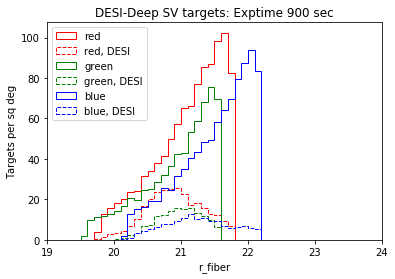


Exptime 1800
red  :  27534 < 22.26  (19.5 % DESI)
green:  16471 < 22.14  (12.6 % DESI)
blue :  19656 < 22.68  (12.8 % DESI)
9945 of 63661  (15.6 %) are DESI targets
DESI targets:  2554 LRG,  1068 ELG,  0 QSO,  7433 BGS,  0 MWS
Selected total of 39000 targets
DESI targets:  1222 LRG,  1068 ELG,  0 QSO,  5330 BGS,  0 MWS


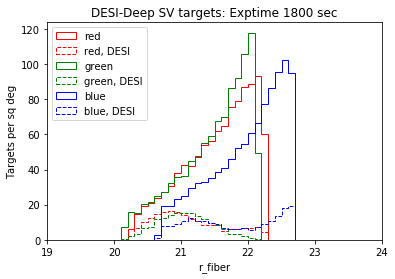


Exptime 3600
red  :  40814 < 22.79  (12.3 % DESI)
green:  28631 < 22.60  (6.5 % DESI)
blue :  31919 < 23.12  (14.8 % DESI)
11591 of 101364  (11.4 %) are DESI targets
DESI targets:  3421 LRG,  3738 ELG,  0 QSO,  5076 BGS,  0 MWS
Selected total of 39000 targets
DESI targets:  1124 LRG,  1495 ELG,  0 QSO,  2944 BGS,  0 MWS


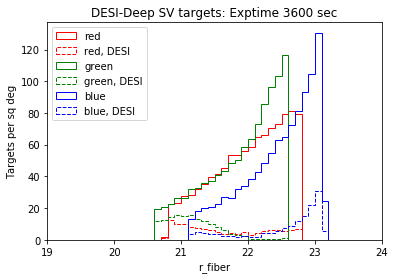


Exptime 7200
red  :  54648 < 23.29  (8.8 % DESI)
green:  43371 < 22.98  (2.9 % DESI)
blue :  53422 < 23.53  (22.1 % DESI)
17896 of 151441  (11.8 %) are DESI targets
DESI targets:  4473 LRG,  11358 ELG,  0 QSO,  2219 BGS,  0 MWS
Selected total of 39000 targets
DESI targets:  1120 LRG,  2784 ELG,  0 QSO,  1452 BGS,  0 MWS


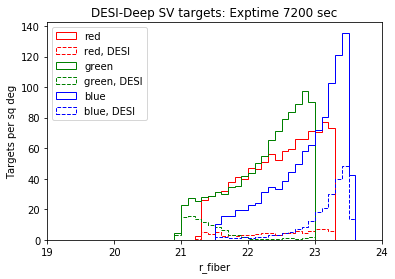


Exptime 14400
red  :  68845 < 23.73  (7.1 % DESI)
green:  67423 < 23.44  (0.8 % DESI)
blue :  79950 < 23.83  (24.9 % DESI)
25365 of 216218  (11.7 %) are DESI targets
DESI targets:  4948 LRG,  19694 ELG,  0 QSO,  742 BGS,  0 MWS
Selected total of 39000 targets
DESI targets:  1025 LRG,  3328 ELG,  0 QSO,  451 BGS,  0 MWS


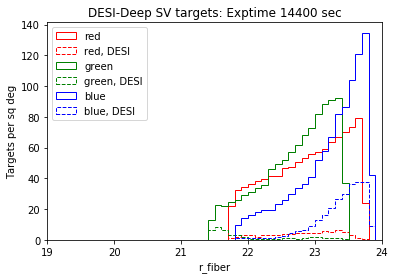

In [69]:
# g-r split for r/g/b samples
gr1 = 0.7
gr2 = 1.1

for t in times:
    cut = m90s[('blue', t)]
    print()
    print('Exptime', t) #, 'blue cut %.2f' % cut)

    #Tc = T[T.mag_r < cut]
    #Pc = P[P.mag_r < cut]
    Rc = R[R.mag_r < cut]
    Gc = G[G.mag_r < cut]

    S = merge_tables([Rc, Gc])
    #print(len(Pc), 'PSF', len(Rc), 'REX', len(Gc), 'Galaxies')
    
    I = np.argsort(S.gr)
    S.cut(I)
    #Sb = S[I[:len(I)//3]]
    #Sg = S[I[len(I)//3 : (2*len(I))//3]]
    #Sr = S[I[(2*len(I))//3 :]]
    Sb = S[S.gr <= gr1]
    Sg = S[(S.gr > gr1) * (S.gr <= gr2)]
    Sr = S[S.gr > gr2]
    #print('blue  g-r:', Sb.gr[0], Sb.gr[-1])
    #print('green g-r:', Sg.gr[0], Sg.gr[-1])
    #print('red   g-r:', Sr.gr[0], Sr.gr[-1]) 
    Sb.sample = np.array(['b']*len(Sb))
    Sg.sample = np.array(['g']*len(Sg))
    Sr.sample = np.array(['r']*len(Sr))
    
    rcut = m90s[('red', t)]
    gcut = m90s[('green',t)]
    bcut = m90s[('blue',t)]
    Sr.cut(Sr.mag_r < rcut)
    Sg.cut(Sg.mag_r < gcut)
    Sb.cut(Sb.mag_r < bcut)
    
    # Bright cut
    b_rcut = rcut - 2.0
    b_gcut = gcut - 2.0
    b_bcut = bcut - 2.0
    Sr.cut(Sr.mag_r > b_rcut)
    Sg.cut(Sg.mag_r > b_gcut)
    Sb.cut(Sb.mag_r > b_bcut)

    S = merge_tables([Sr,Sg,Sb])
    I,J,d = match_radec(targets.ra, targets.dec, S.ra, S.dec, 0.1/3600)
    scount = Counter(S.sample[J])
    #print('DESI target matches by sample:', Counter(S.sample[J]).most_common())
    print('red  : % 6i < %.2f  (%.1f %% DESI)' % (len(Sr), rcut, 100.*scount['r']/len(Sr)))
    print('green: % 6i < %.2f  (%.1f %% DESI)' % (len(Sg), gcut, 100.*scount['g']/len(Sg)))
    print('blue : % 6i < %.2f  (%.1f %% DESI)' % (len(Sb), bcut, 100.*scount['b']/len(Sb)))

    print(len(I), 'of', len(S), ' (%.1f %%) are DESI targets' % (100. * len(I)/len(S)))
    mask = targetmask.desi_mask
    print('DESI targets: ',
          np.sum((targets.desi_target[I] & mask.LRG)>0), 'LRG, ',
          np.sum((targets.desi_target[I] & mask.ELG)>0), 'ELG, ',
          np.sum((targets.desi_target[I] & mask.QSO)>0), 'QSO, ',
          np.sum((targets.desi_target[I] & mask.BGS_ANY)>0), 'BGS, ',
          np.sum((targets.desi_target[I] & mask.MWS_ANY)>0), 'MWS')

    Ir,Jr,_ = match_radec(targets.ra, targets.dec, Sr.ra, Sr.dec, 0.1/3600)
    Ig,Jg,_ = match_radec(targets.ra, targets.dec, Sg.ra, Sg.dec, 0.1/3600)
    Ib,Jb,_ = match_radec(targets.ra, targets.dec, Sb.ra, Sb.dec, 0.1/3600)
    dt = targets.desi_target.dtype
    Sr.desi_target = np.zeros(len(Sr), dt)
    Sr.desi_target[Jr] = targets.desi_target[Ir]
    Sg.desi_target = np.zeros(len(Sg), dt)
    Sg.desi_target[Jg] = targets.desi_target[Ig]
    Sb.desi_target = np.zeros(len(Sb), dt)
    Sb.desi_target[Jb] = targets.desi_target[Ib]
    S = merge_tables([Sr,Sg,Sb])
    
    # We've got a 2-degree radius circle (bigger than DESI) and we want some oversampling in case fibers
    # have limited patrol radius -- a 5x oversampling gives a number of targets:
    Ntarget = 39000
    #Ndesi = Ntarget // 4

    # Split evenly into the r/g/b samples
    Ns = Ntarget//3
    # Select 25% (or more) DESI targets
    Ndesi = Ns//4

    # Compute DESI-unmatched samples
    keep = np.ones(len(Sr), bool)
    keep[Jr] = False
    JNr = np.flatnonzero(keep)
    keep = np.ones(len(Sg), bool)
    keep[Jg] = False
    JNg = np.flatnonzero(keep)
    keep = np.ones(len(Sb), bool)
    keep[Jb] = False
    JNb = np.flatnonzero(keep)

    np.random.seed(42)

    # Are DESI targets > 25%?
    if scount['r'] > Ndesi:
        # Just randomly sample the whole set
        SSr = Sr[np.random.permutation(len(Sr))[:Ns]]
    else:
        Sr_desi = Sr[np.random.permutation(Jr)[:Ndesi]]
        Sr_nondesi = Sr[np.random.permutation(JNr)[:(Ns-len(Sr_desi))]]
        SSr = merge_tables([Sr_desi, Sr_nondesi])

    if scount['g'] > Ndesi:
        # Just randomly sample the whole set
        SSg = Sg[np.random.permutation(len(Sg))[:Ns]]
    else:
        Sg_desi = Sg[np.random.permutation(Jg)[:Ndesi]]
        Sg_nondesi = Sg[np.random.permutation(JNg)[:(Ns-len(Sg_desi))]]
        SSg = merge_tables([Sg_desi, Sg_nondesi])
        
    if scount['b'] > Ndesi:
        # Just randomly sample the whole set
        SSb = Sb[np.random.permutation(len(Sb))[:Ns]]
    else:
        Sb_desi = Sb[np.random.permutation(Jb)[:Ndesi]]
        Sb_nondesi = Sb[np.random.permutation(JNb)[:(Ns-len(Sb_desi))]]
        SSb = merge_tables([Sb_desi, Sb_nondesi])
        
    SS = merge_tables([SSr, SSg, SSb])
    SS = SS[np.random.permutation(len(SS))]
    print('Selected total of', len(SS), 'targets')
    print('DESI targets: ',
          np.sum((SS.desi_target & mask.LRG)>0), 'LRG, ',
          np.sum((SS.desi_target & mask.ELG)>0), 'ELG, ',
          np.sum((SS.desi_target & mask.QSO)>0), 'QSO, ',
          np.sum((SS.desi_target & mask.BGS_ANY)>0), 'BGS, ',
          np.sum((SS.desi_target & mask.MWS_ANY)>0), 'MWS')

    SS.writeto('desi-deep-%4.2f.fits' % (t/3600))

    JJr = np.flatnonzero(SSr.desi_target)
    JJg = np.flatnonzero(SSg.desi_target)
    JJb = np.flatnonzero(SSb.desi_target)
    
    plt.figure(figsize=(6,4))
    plt.clf()
    sqdeg = np.pi * radius**2
    ha = dict(range=(19,24), bins=50, histtype='step')
    #plt.hist(Sr.mag_r, weights=[1./sqdeg]*len(Sr), label='red', color='r', **ha)
    #plt.hist(Sr.mag_r[Jr], weights=[1./sqdeg]*len(Jr), label='red, DESI', color='r', linestyle='--', **ha)    
    #plt.hist(Sg.mag_r, weights=[1./sqdeg]*len(Sg), label='green', color='g', **ha)
    #plt.hist(Sg.mag_r[Jg], weights=[1./sqdeg]*len(Jg), label='green, DESI', color='g', linestyle='--', **ha)    
    #plt.hist(Sb.mag_r, weights=[1./sqdeg]*len(Sb), label='blue', color='b', **ha)
    #plt.hist(Sb.mag_r[Jb], weights=[1./sqdeg]*len(Jb), label='blue, DESI', color='b', linestyle='--', **ha)
    plt.hist(SSr.mag_r, weights=[1./sqdeg]*len(SSr), label='red', color='r', **ha)
    plt.hist(SSr.mag_r[JJr], weights=[1./sqdeg]*len(JJr), label='red, DESI', color='r', linestyle='--', **ha)    
    plt.hist(SSg.mag_r, weights=[1./sqdeg]*len(SSg), label='green', color='g', **ha)
    plt.hist(SSg.mag_r[JJg], weights=[1./sqdeg]*len(JJg), label='green, DESI', color='g', linestyle='--', **ha)    
    plt.hist(SSb.mag_r, weights=[1./sqdeg]*len(SSb), label='blue', color='b', **ha)
    plt.hist(SSb.mag_r[JJb], weights=[1./sqdeg]*len(JJb), label='blue, DESI', color='b', linestyle='--', **ha)
    plt.xlim(19,24)
    plt.legend(loc='upper left')
    plt.xlabel('r_fiber')
    plt.ylabel('Targets per sq deg')
    plt.title('DESI-Deep SV targets: Exptime %i sec' % t)
    plt.savefig('exptime-%4.2f.png' % (t/3600))
    plt.show()
    

In [48]:
pwd

'/global/u1/d/dstn'

In [27]:
targetmask.desi_mask.LRG, targetmask.desi_mask.ELG, targetmask.desi_mask.QSO, targetmask.desi_mask.BGS_ANY, targetmask.desi_mask.MWS_ANY, targetmask.desi_mask.ANCILLARY_ANY

(1, 2, 4, 1152921504606846976, 2305843009213693952, 4611686018427387904)

In [24]:
targetmask.desi_mask

desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 3000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000}}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3500, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3400}}]
  - [LRG_1PASS,        3, "LRG observed in 1st pass", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}}]
  - [LRG_2PASS,        4, "LRG observed in 2nd pass", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}}]
  - [LRG_NORTH,        8, "LRG from Bok/Mosaic data", {'obsconditions': 'DARK', 'priori

In [ ]:
Sr.cut(Sr.mag_r < m90s[('red', t)])
Sg.cut(Sg.mag_r < m90s[('green',t)])
len(Sr), len(Sg), len(Sb)

In [ ]:
S = merge_tables([Sr,Sg,Sb])
plothist(S.gr, S.rz, **ha);

In [ ]:
len(S)

In [ ]:
I,J,d = match_radec(targets.ra, targets.dec, S.ra, S.dec, 0.1/3600)

In [ ]:
len(I)

In [ ]:
cut = 23.83
Tc = T[T.mag_r < cut]
Pc = P[P.mag_r < cut]
Rc = R[R.mag_r < cut]
Gc = G[G.mag_r < cut]

ca = ha.copy()
ca.update(nbins=(30,30))
N_P,_,_ = plothist(Pc.gr, Pc.rz, **ca);
plt.show()

N_R,xe,ye = plothist(Rc.gr, Rc.rz, **ca);
plt.show()

plt.clf()
plt.imshow(1 * np.logical_or(N_R.T < 100, N_R.T > N_P.T), vmin=0, vmax=1, origin='lower', cmap='hot')
#plt.imshow(N_R.T - N_P.T, origin='lower')
plt.colorbar()

In [ ]:
Rc.xbin = np.clip(np.floor(len(xe) * (Rc.gr - xe[0]) / (xe[-1] - xe[0])).astype(int), 0, len(xe)-2)
Rc.ybin = np.clip(np.floor(len(ye) * (Rc.rz - ye[0]) / (ye[-1] - ye[0])).astype(int), 0, len(ye)-2)

In [ ]:
r = N_R.T[Rc.ybin, Rc.xbin]
p = N_P.T[Rc.ybin, Rc.xbin]
Rc.noP = np.logical_or(p < 100, r > p)

In [ ]:
N_P.shape

In [ ]:
len(xe)

In [ ]:
len(xe)

In [ ]:
len(xe) * (-0.40001 - xe[0]) / (xe[-1] - xe[0])

In [ ]:
plt.imshow(N_P.T * (N_P.T < 500), origin='lower')

In [ ]:
Counter(N_P.ravel() < 500)

In [ ]:
np.sum(N_P[N_P < 500])

In [ ]:
np.sum(N_P[N_P >= 500])

In [ ]:
plothist(G.gr, G.rz, range=((-1,3),(-1,3)));

In [ ]:
# t=900, blue galaxy
cut = 22.18

In [ ]:
I = np.flatnonzero((T.mag_r < cut) * (T.mag_r > (cut-1)))
plothist(T.gr[I], T.rz[I], range=((-1,3),(-1,3)));

In [ ]:
plothist(R.gr, R.rz, range=((-1,3),(-1,3)));

In [ ]:
plothist(P.gr, P.rz, range=((-1,3),(-1,3)));